In [324]:
!pip install more-itertools networkx

In [1023]:
import math
import heapq as hpq
import time
from typing import List, Tuple, Union

import numpy as np
import pandas as pd
import scipy.stats as ss
from itertools import combinations
from more_itertools import powerset
import networkx as nx

import matplotlib.pyplot as plt

In [472]:
def semi_connected(G: nx.MultiGraph):
    comp = { v: None for v in G.nodes }
    nontrivial_cnt = 0
    for label, component in enumerate(nx.connected_components(G)):
        for v in component:
            comp[v] = label
        
        nontrivial_cnt += int(len(component) > 1)
        
    return nontrivial_cnt <= 1


In [526]:
def eulerize(G: nx.MultiGraph, return_graph = True):
    """
    Based on NetworkX.eulerize
    
    Transforms a graph into an Eulerian graph

    Parameters
    ----------
    G : NetworkX graph
       An undirected graph

    Returns
    -------
    G : NetworkX multigraph

    Raises
    ------
    NetworkXError
       If the graph is not connected.

    """
    H = nx.MultiGraph(G)
    
    if (H.order() == 0):
        raise nx.NetworkXPointlessConcept("Cannot Eulerize null graph")
        
    #if (not nx.is_connected(H)):
    #    raise nx.NetworkXError("G is not connected")
    
    if (not semi_connected(H)):
        raise nx.NetworkXError("G is not semi-connected")
        
    odd_degree_nodes = [n for n, d in H.degree() if d % 2 == 1]
    if (len(odd_degree_nodes) == 0):
        return (H, 0) if (return_graph) else 0

    # get all shortest paths between vertices of odd degree
    '''odd_deg_pairs_paths = [
        (m, {n: (
            nx.shortest_path(G, source = m, target = n, weight = "weight"),
            nx.shortest_path_length(G, source = m, target = n, weight = "weight")
        )})
        for m, n in combinations(odd_degree_nodes, 2)
    ]'''
    
    comp = { v: None for v in H.nodes }
    for label, component in enumerate(nx.connected_components(H)):
        for v in component:
            comp[v] = label

    odd_deg_pairs_paths = []
    for m, n in combinations(odd_degree_nodes, 2):
        if (comp[m] == comp[n]):
            odd_deg_pairs_paths.append((m, {n: (
                nx.shortest_path(G, source = m, target = n, weight = "weight"),
                nx.shortest_path_length(G, source = m, target = n, weight = "weight")
            )}))

    # build additional edges between odd vertices
    Gp = nx.Graph()
    for n, Ps in odd_deg_pairs_paths:
        for m, (P, W) in Ps.items():
            if (n != m):
                Gp.add_edge(m, n, weight = W, path = P)
                
    # find the minimum weight matching of edges in the weighted graph
    best_matching = nx.Graph(list(nx.min_weight_matching(Gp)))
    
    # duplicate each edge along each path in the set of paths in Gp
    additional_weight = 0
    for m, n in best_matching.edges():
        additional_weight += Gp[m][n]["weight"]
        
        if (return_graph):
            path = Gp[m][n]["path"]
            H.add_edges_from(nx.utils.pairwise(path))

    return (H, additional_weight) if (return_graph) else additional_weight


In [527]:
G = nx.complete_graph(10)
H = nx.eulerize(G)
print(nx.is_eulerian(G), nx.is_eulerian(H))
H, _ = eulerize(G)
print(nx.is_eulerian(G), nx.is_eulerian(H))

False True
False True


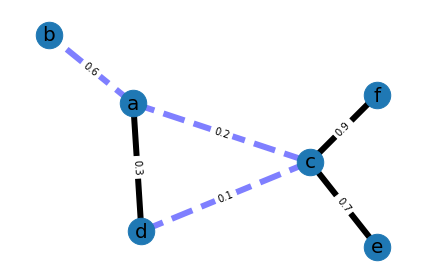

In [738]:
G = nx.Graph()

G.add_edge("a", "b", weight=0.6)
G.add_edge("a", "c", weight=0.2)
G.add_edge("c", "d", weight=0.1)
G.add_edge("c", "e", weight=0.7)
G.add_edge("c", "f", weight=0.9)
G.add_edge("a", "d", weight=0.3)

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] in [0.3, 0.7, 0.9]]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] in [0.1, 0.2, 0.6]]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [739]:
def ChinesePostmanProblem(G: nx.MultiGraph, return_cycle = True):
    if (return_cycle):
        H, w = eulerize(G)
        w += G.size(weight = "weight")
        
        deg = dict(H.degree)
        for v, d in deg.items():
            if (d == 0):
                H.remove_node(v)
        
        cycle, _ = zip(*list(nx.eulerian_circuit(H)))
        return list(cycle), w
    
    else:
        return eulerize(G, return_graph = False) + G.size(weight = "weight")


In [740]:
print(ChinesePostmanProblem(G))
print(ChinesePostmanProblem(nx.complete_graph(5)))
print(ChinesePostmanProblem(nx.complete_bipartite_graph(2, 3)))

(['a', 'd', 'c', 'f', 'c', 'e', 'c', 'a', 'b'], 5.0)
([0, 4, 3, 2, 4, 1, 3, 0, 2, 1], 10.0)
([0, 4, 1, 2, 1, 3, 0, 2], 8.0)


In [801]:
def RuralPostmanProblemBaseline(G: nx.MultiGraph):
    edges = G.edges(data = True)
    main_edges = list(filter(lambda ed: not "travel" in ed[2] or not ed[2]["travel"], edges))
    travel_edges = list(filter(lambda ed: "travel" in ed[2] and ed[2]["travel"], edges))
    
    base_H = nx.MultiGraph(main_edges)
    
    best = None
    for st in powerset(travel_edges):
        H = nx.MultiGraph(base_H)
        H.add_edges_from(st)
        
        if (not semi_connected(H)):
            continue
        
        w = ChinesePostmanProblem(H, return_cycle = False)
        
        if (best is None or best[0] > w):
            best = (w, st)
    
    base_H.add_edges_from(best[1])
    cycle, w = ChinesePostmanProblem(base_H)
    
    return cycle, w


In [742]:
H = nx.Graph()

H.add_edge("a", "b", weight=6, travel=True)
H.add_edge("a", "c", weight=2, travel=True)
H.add_edge("c", "d", weight=1, travel=True)
H.add_edge("c", "e", weight=7)
H.add_edge("c", "f", weight=9)
H.add_edge("a", "d", weight=3)

RuralPostmanProblemBaseline(H)

(['a', 'c', 'f', 'c', 'e', 'c', 'd'], 38.0)

In [743]:
class RPPSubproblem:

    def __init__(self, G, task):
        self.G = nx.MultiGraph(G)
        self.cost = math.inf
        self.task = task
        
        if (semi_connected(G)):
            self.cost = ChinesePostmanProblem(G, return_cycle = False)


    def __lt__(self, p):
        return self.cost < p.cost


In [744]:
def get_max_otp(nodes, otp):
    ans = None
    for u, v in combinations(nodes, 2):
        if (otp[u][v] is None):
            continue

        if (ans is None or ans[0] < otp[u][v]):
            ans = (otp[u][v], u, v)
            
    return ans


def get_min_otp(nodes, otp):
    ans = None
    for u, v in combinations(nodes, 2):
        if (otp[u][v] is None):
            continue

        if (ans is None or ans[0] > otp[u][v]):
            ans = (otp[u][v], u, v)
            
    return ans


def get_random_otp(nodes, otp):
    res = []
    for u, v in combinations(nodes, 2):
        if (otp[u][v] is None):
            continue

        res.append((otp[u][v], u, v))
    
    if (len(res) == 0):
        return None
    
    return res[np.random.randint(len(res))]


In [930]:
def RuralPostmanProblem(G: nx.MultiGraph, get_otp = get_max_otp, return_stats = False):
    edges = G.edges(data = True)
    main_edges = list(filter(lambda ed: not "travel" in ed[2] or not ed[2]["travel"], edges))
    travel_edges = list(filter(lambda ed: "travel" in ed[2] and ed[2]["travel"], edges))
    
    if (len(travel_edges) == 0):
        cycle, w = ChinesePostmanProblem(G)
        return (cycle, w, 0, 0) if (return_stats) else (cycle, w)
    
    nodes = list(G.nodes)
    
    travel_dist = { v: dict() for v in nodes }
    true_dist = { v: dict() for v in nodes }
    
    for u, v in combinations(nodes, 2):
        travel_dist[u][v] = math.inf
        travel_dist[v][u] = math.inf
        
        true_dist[u][v] = math.inf
        true_dist[v][u] = math.inf
    
    travel_G = nx.MultiGraph(travel_edges)
    
    for u, dist in nx.all_pairs_dijkstra_path_length(travel_G):
        for v, w in dist.items():
            travel_dist[u][v] = w
            travel_dist[v][u] = w
    
    for u, dist in nx.all_pairs_dijkstra_path_length(G):
        for v, w in dist.items():
            true_dist[u][v] = w
            true_dist[v][u] = w

    cover_G = nx.MultiGraph(main_edges)
    cover_G.add_nodes_from(travel_G.nodes)
    
    comp = { v: None for v in nodes }
    for label, component in enumerate(nx.connected_components(cover_G)):
        for v in component:
            comp[v] = label
            
    otp = { v: {v: None} for v in nodes }
    ot_path = { (u, v): None for u, v in combinations(nodes, 2) }
    for u, v in combinations(nodes, 2):
        otp[u][v] = None
        
        if (comp[u] != comp[v] and \
            travel_dist[u][v] != math.inf and \
            true_dist[u][v] != math.inf and \
            travel_dist[u][v] == true_dist[u][v]):
            #not (comp[u] is None) and \
            #not (comp[v] is None) and \
            #comp[u] != comp[v]):
            
            otp[u][v] = true_dist[u][v]
            
            #print(travel_G.edges(data = True))
            #print(u, v, comp[u], comp[v], travel_dist[u][v], true_dist[u][v])
            
            sp = nx.shortest_path(travel_G, u, v, weight = "weight")
            ot_path[(u, v)] = []
            
            for i in range(1, len(sp)):
                ot_path[(u, v)].append((sp[i - 1], sp[i], G.edges[sp[i - 1], sp[i]]))
        
        otp[v][u] = otp[u][v]
        
        if (not (otp[u][v] is None)):
            for e in ot_path[(u, v)]:
                cover_G.add_edge(e[0], e[1], key = (u, v), weight = 0)
    
    del travel_dist, true_dist, travel_G
    
    otp_seq = []
    res = get_otp(nodes, otp)
    while (not (res is None)):
        w, u, v = res
        otp[u][v] = None
        otp[v][u] = None
        
        otp_seq.append((w, u, v))
        
        res = get_otp(nodes, otp)
        
    pq = []
    hpq.heappush(pq, RPPSubproblem(cover_G, 0))
    del cover_G
    
    iter_count = 0
    while (len(pq) > 0):
        iter_count += 1
        s = hpq.heappop(pq)
        cur_G = s.G
        task = s.task
        if (task >= len(otp_seq)):
            cycle, w = ChinesePostmanProblem(cur_G)
            return (cycle, w, iter_count, len(otp_seq)) if (return_stats) else (cycle, w)

        w, u, v = otp_seq[task]
        
        #print(u, v, w)
        
        #print(cur_G.edges(data = True))
        #print()
        
        #cur_G.remove_edge(u, v, key = (u, v, 0))
        for e in ot_path[(u, v)]:
            cur_G.remove_edge(e[0], e[1], key = (u, v))
        
        hpq.heappush(pq, RPPSubproblem(cur_G, task + 1))
        
        #print(cur_G.edges(data = True))
        #print()
        
        #cur_G.add_edge(u, v, key = (u, v, w), weight = w)
        for e in ot_path[(u, v)]:
            cur_G.add_edge(e[0], e[1], key = (u, v), weight = e[2]["weight"])
        
        hpq.heappush(pq, RPPSubproblem(cur_G, task + 1))
        
        #print(cur_G.edges(data = True))
        #print()
        
    raise Exception("something has gone completely wrong...")


In [931]:
print(RuralPostmanProblem(H, get_max_otp))
print(RuralPostmanProblem(H, get_min_otp))
print(RuralPostmanProblem(H, get_random_otp))

(['a', 'c', 'f', 'c', 'e', 'c', 'd'], 38.0)
(['a', 'c', 'f', 'c', 'e', 'c', 'd'], 38.0)
(['a', 'c', 'f', 'c', 'e', 'c', 'd'], 38.0)


In [933]:
def load_graph(path, weighted = False, integer_labels = True):
    G = nx.Graph()
    
    with open(path, "r") as file:
        for line in file.readlines()[1 :]:
            tokens = line.strip().split()
            
            if (integer_labels):
                tokens[0 : 2] = list(map(int, tokens[0 : 2]))
            
            if (weighted):
                tokens[2] = float(tokens[2])
            
            if (not weighted):
                G.add_edge(tokens[0], tokens[1], weight = 1)
            else:
                G.add_edge(tokens[0], tokens[1], weight = tokens[2])
                
    return G


In [972]:
G = load_graph("data/road-chesapeake.txt", weighted = False)

In [973]:
edges = list(G.edges)
ind = np.random.choice(np.arange(len(edges)), size = 7)

for i in ind:
    u, v = edges[i]
    G.edges[u, v]["travel"] = True

In [974]:
%time res = RuralPostmanProblem(G, get_otp = get_max_otp, return_stats = True)
print(res[1 :])

%time res = RuralPostmanProblem(G, get_otp = get_min_otp, return_stats = True)
print(res[1 :])

%time res = RuralPostmanProblem(G, get_otp = get_random_otp, return_stats = True)
print(res[1 :])

CPU times: user 251 ms, sys: 15 µs, total: 251 ms
Wall time: 252 ms
(172.0, 1, 0)
CPU times: user 302 ms, sys: 3.99 ms, total: 306 ms
Wall time: 308 ms
(172.0, 1, 0)
CPU times: user 126 ms, sys: 0 ns, total: 126 ms
Wall time: 125 ms
(172.0, 1, 0)


In [1047]:
max_times = []
min_times = []
random_times = []

def run_tests():
    for sz in range(5, 81, 5):
        print("sz =", sz)

        iter_count = 10
        overall_max, overall_min, overall_random = 0.0, 0.0, 0.0
        for it in range(iter_count):
            G = load_graph("graph_data/road-chesapeake.txt", weighted = False)
            edges = list(G.edges)
            ind = np.random.choice(np.arange(len(edges)), size = sz)

            for i in ind:
                u, v = edges[i]
                G.edges[u, v]["travel"] = True
        
            start = time.time()
            res = RuralPostmanProblem(G, get_otp = get_max_otp, return_stats = True)
            end = time.time()
            overall_max += (end - start)

            start = time.time()
            res = RuralPostmanProblem(G, get_otp = get_min_otp, return_stats = True)
            end = time.time()
            overall_min += (end - start)

            start = time.time()
            res = RuralPostmanProblem(G, get_otp = get_random_otp, return_stats = True)
            end = time.time()
            overall_random += (end - start)
        
        print(overall_max / iter_count, overall_min / iter_count, overall_random / iter_count)

run_tests()

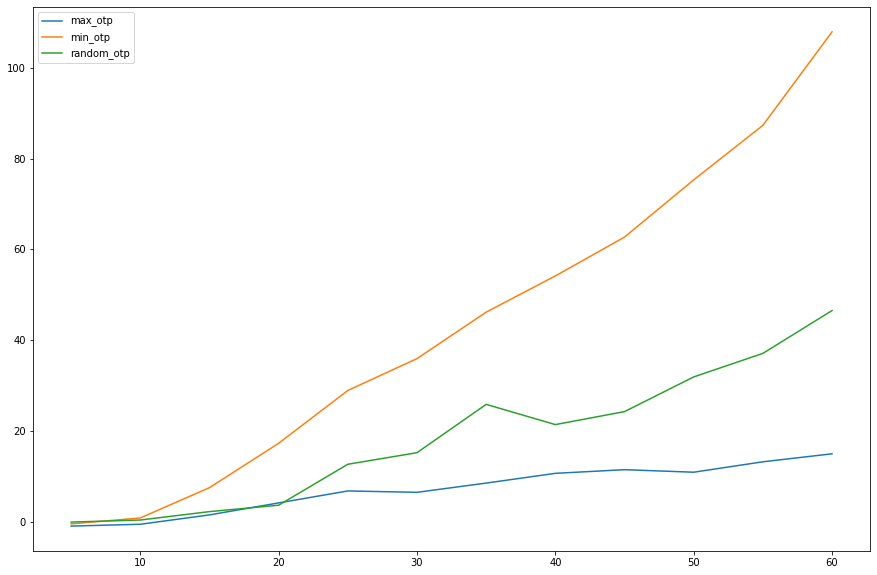

In [1048]:
plt.rcParams["figure.figsize"] = (15, 10)

plt.plot(np.arange(5, 61, 5), max_times, label = "max_otp")
plt.plot(np.arange(5, 61, 5), min_times, label = "min_otp")
plt.plot(np.arange(5, 61, 5), random_times, label = "random_otp")

plt.legend()
plt.show()

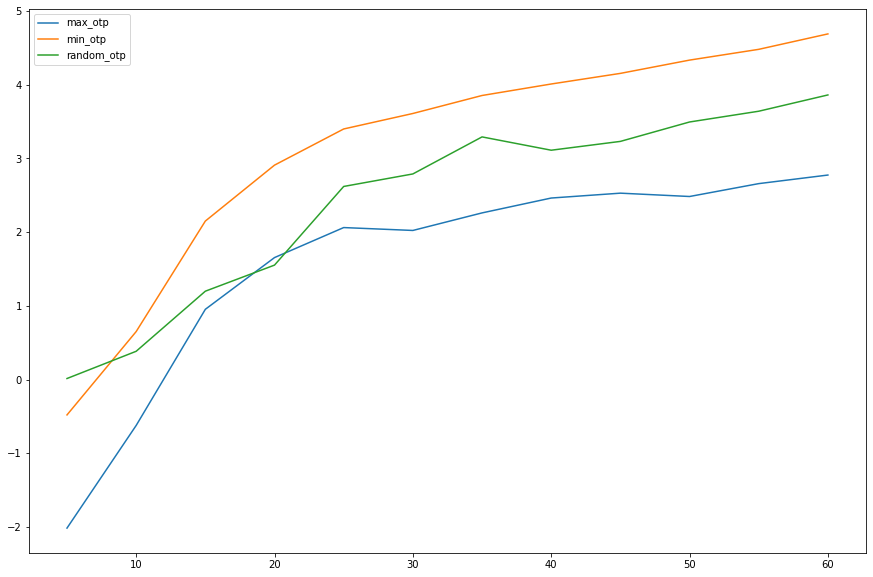

In [1049]:
plt.rcParams["figure.figsize"] = (15, 10)

plt.plot(np.arange(5, 61, 5), np.log(1 + max_times), label = "max_otp")
plt.plot(np.arange(5, 61, 5), np.log(1 + min_times), label = "min_otp")
plt.plot(np.arange(5, 61, 5), np.log(1 + random_times), label = "random_otp")

plt.legend()
plt.show()